In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.random.seed = 42

import numpy as np

import random
import gc
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Configs

In [2]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 5
log_interval = 10

In [3]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

# Load dataset

In [4]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(), 
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])
                                )

mnist_testset = datasets.MNIST(root='../data', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                                    ])
                              )

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size_train, True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size_test, True)

In [6]:
torch.utils.data.Subset(train_loader, [1, 2, 3]).dataset

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

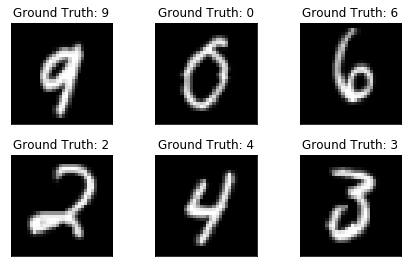

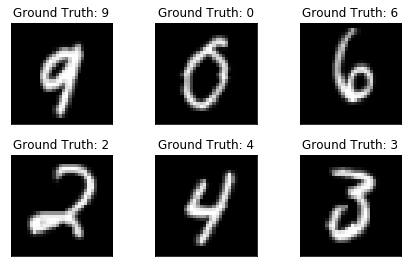

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Helper functions

In [9]:
def train(epoch, net, optimizer, train_loader, v=1, track=0):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (v > 0) and (batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        if track > 0:
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#         torch.save(network.state_dict(), 'model.pth')
#         torch.save(optimizer.state_dict(), 'optimizer.pth')

In [10]:
def test(net, optimizer, test_loader, v=1, track=0):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if track > 0:
        test_losses.append(test_loss)
    if v>0:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct.item()/len(test_loader.dataset)

In [11]:
def kfold(k, N, epochs, model, optimizer, state_dict, train_loader):
    loss_avg = 0
    acc_avg = 0
    for i in range(k):
        model.load_state_dict(state_dict)
        epoch = 0
        count = 0
        min_error = 100
        max_acc = 1
        train_mask = []
        val_mask = []
        for i in range(60000):
            if i%k == 0:
                val_mask.append(i)
            else:
                train_mask.append(i)
        X_train = torch.utils.data.Subset(train_loader.dataset, train_mask)
        X_val = torch.utils.data.Subset(train_loader.dataset, val_mask)
        X_train_l = torch.utils.data.DataLoader(X_train, batch_size_train, True)
        X_val_l = torch.utils.data.DataLoader(X_val, batch_size_test, True)
        while (epoch < epochs and count < 1):
            train(epoch, model, optimizer, X_train_l, 0)
            test_loss, test_acc = test(model, optimizer, X_val_l, 0)
            epoch += 1
            if test_loss >= min_error:
                count += 1
            else:
                min_error = test_loss
                max_acc = test_acc
            print('{:.4f} - '.format(test_loss), end='')
        loss_avg += min_error
        acc_avg += max_acc
        print('{:.4f} ({:4.2f}%) |'.format(min_error, 100*max_acc), end='')
    print('>')
    return loss_avg/k, acc_avg/k

# Architectures

## MLP

In [12]:
class MLP(nn.Module):
    """MLP with 3 ReLU hidden layers and 1 softmax output layer"""
    
    def __init__(self, H, D):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(D)
        
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.dropout(x)
        x = self.relu(self.fc1(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc3(x)) # H
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x)) # 10
        return x

## CNN

In [13]:
class CNN(nn.Module):
    """CNN inspired in LeNet 5"""
    def __init__(self, D):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(D)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 6 @ 14x14
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # 16 @ 5x5
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) # 120
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 84
        x = self.dropout(x)
        x = self.fc3(x)         # 10
        return F.log_softmax(x)

# MLP

In [14]:
models = []
for H in [30, 60, 100, 300, 600]:
    for D in [0, 0.3, 0.5]:
        model = MLP(H, D)
        copy = MLP(H, D)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print('D =', D, 'H =', H)
        loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
        print()
        models.append((H, D, loss, acc)) 

D = 0 H = 30


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0.2620 - 0.2528 - 0.2597 - 0.2528 (92.84%) |

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-c4037e035b5c>", line 8, in <module>
    loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
  File "<ipython-input-11-5d8352d2659c>", line 22, in kfold
    train(epoch, model, optimizer, X_train_l, 0)
  File "<ipython-input-9-687e4c1666b3>", line 3, in train
    for batch_idx, (data, target) in enumerate(train_loader):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 615, in __next__
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 615, in <listcomp>
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 103, in __getitem__
    return self.d

KeyboardInterrupt: 

In [ ]:
models

In [ ]:
mlp = MLP(300, 0)
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
test(mlp, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, mlp, optimizer, train_loader, v=1, track=1)
    test(mlp, optimizer, test_loader, v=1, track=1)

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'mlp.png'), bbox_inches='tight')
plt.show()

# CNN

In [ ]:
models_cnn = []
for D in [0, 0.3, 0.5]:
    model = CNN(D)
    copy = CNN(D)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print('D =', D)
    loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
    print()
    models_cnn.append((D, loss, acc)) 

In [ ]:
models_cnn

In [ ]:
train_losses_mlp = train_losses[:]
test_losses_mlp = test_losses[:]

In [ ]:
cnn = CNN(0)
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
test(cnn, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, cnn, optimizer, train_loader, v=1, track=1)
    test(cnn, optimizer, test_loader, v=1, track=1)

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'cnn.png'), bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure()

plt.subplot(1,2,1)
plt.plot(train_counter, train_losses_mlp, color='blue', zorder=1)
plt.scatter(test_counter, test_losses_mlp, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('MLP')

plt.subplot(1,2,2)
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('CNN')

plt.savefig(os.path.join(image_dir, 'learning_curves.png'), bbox_inches='tight')